In [164]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

save_root_dir = 'archive/tennis_abstract_dfs_good_Elos'
backup_root_dir = 'archive/tennis_abstract_dfs_Elo_backup'
df_root_dir = 'tennis_abstract_dfs'
big_df_name = 'big_df.pkl'
surfs = ['Clay', 'Grass', 'Hard']
# poly3d_coeefs = [-3.62592888,  5.42864825, -0.86041857,  0.02900003]
poly3d_coeefs = [-3.51591704,  5.26301386, -0.79325641,  0.02302555]
swr_baseline = 63.5
rwr_baseline = 36.5


In [165]:
top_200_names = []
for file in tqdm(os.listdir(df_root_dir)):
    name = file[:-4]
    file_name = f'{df_root_dir}/{file}'
    p_df = pd.read_pickle(f'{df_root_dir}/{file}')
    latest_rank = p_df['rank'].iloc[-1]
    if latest_rank:
        latest_rank = int(latest_rank)
        if latest_rank < 200:
            top_200_names.append(name)
len(top_200_names)

  0%|          | 0/380 [00:00<?, ?it/s]

100%|██████████| 380/380 [00:04<00:00, 92.24it/s] 


195

In [167]:
def restore_df(player):
    backup_path = f'{backup_root_dir}/{player}.pkl'
    file_path = f'{df_root_dir}/{player}.pkl'
    og = pd.read_pickle(backup_path)
    pd.to_pickle(og, file_path)

def restore_all_dfs(all_names):
    for name in tqdm(all_names):
        restore_df(name)
        
def save_all_dfs(top_200_names):
    for name in tqdm(top_200_names):
        save_df(name)

def save_df(player):
    file_path = f'{df_root_dir}/{player}.pkl'
    save_path = f'{save_root_dir}/{player}.pkl'
    og = pd.read_pickle(file_path)
    og = og.sort_values(by=['date', 'round_val', 'formatted_opp'], ascending=[True, False, True]).reset_index(drop=True)
    # while True:
    #     last_match = og.iloc[og.index[-1]]
    #     last_opp = last_match['formatted_opp']
    #     opp_df = pd.read_pickle(f'{df_root_dir}/{last_opp}.pkl')
    #     all_good = (opp_df['date'] == last_match['date']) & (opp_df['formatted_opp'] == player) & (opp_df['round_val'] == last_match['round_val'])
    #     if not all_good.any():
    #         print(f"Error: {player} and {last_opp} do not match on {last_match['date']} in {last_match['round_val']}")
    #         og = og.drop(og.index[-1])
    #     else:
    #         break
    pd.to_pickle(og, save_path)

def backup_all_dfs(top_200_names):
    for name in tqdm(top_200_names):
        backup_df(name)

def backup_df(player):
    file_path = f'{df_root_dir}/{player}.pkl'
    save_path = f'{backup_root_dir}/{player}.pkl'
    og = pd.read_pickle(file_path)
    og = og.sort_values(by=['date', 'round_val', 'formatted_opp'], ascending=[True, False, True]).reset_index(drop=True)
    # while True:
    #     last_match = og.iloc[og.index[-1]]
    #     last_opp = last_match['formatted_opp']
    #     opp_df = pd.read_pickle(f'{df_root_dir}/{last_opp}.pkl')
    #     all_good = (opp_df['date'] == last_match['date']) & (opp_df['formatted_opp'] == player) & (opp_df['round_val'] == last_match['round_val'])
    #     if not all_good.any():
    #         print(f"Error: {player} and {last_opp} do not match on {last_match['date']} in {last_match['round_val']}")
    #         og = og.drop(og.index[-1])
    #     else:
    #         break
    pd.to_pickle(og, save_path)

# save_all_dfs(top_200_names)
# backup_all_dfs(top_200_names)
# restore_all_dfs(top_200_names)

top_200_names = []
for file in tqdm(os.listdir(df_root_dir)):
    name = file[:-4]
    file_name = f'{df_root_dir}/{file}'
    p_df = pd.read_pickle(f'{df_root_dir}/{file}')
    latest_rank = p_df['rank'].iloc[-1]
    if latest_rank:
        latest_rank = int(latest_rank)
        if latest_rank < 200:
            top_200_names.append(name)
len(top_200_names)


195


In [142]:
def assert_column_is_numeric_and_populated(df, column_name):
    assert column_name in df.columns, f"AssertionError: Column '{column_name}' not found in DataFrame."

    is_numeric = pd.api.types.is_numeric_dtype(df[column_name])
    assert is_numeric, f"AssertionError: Column '{column_name}' is not of a numeric data type. Actual dtype: {df[column_name].dtype}."

    has_no_nans = df[column_name].notna().all() 
    assert has_no_nans, f"AssertionError: Column '{column_name}' contains NaN/missing values."
    return True

In [143]:
def update_player(player):
    p_df = pd.read_pickle(f'{df_root_dir}/{player}.pkl')
    surfs = ['c', 'g', 'h', 'o']
    types = ['s', 'r', 'r']
    try:
        for surf in surfs:
            for t in types:
                assert_column_is_numeric_and_populated(p_df, f'R_{surf}_{t}')
                assert_column_is_numeric_and_populated(p_df, f'oR_{surf}_{t}')
    except AssertionError as e:
        print(f"AssertionError for player {player}: {e}")
        return
    cols_to_add = ['E_s', 'E_r', 'E_o', 'E_os', 'E_or', 'E_oo', 'E_ms', 'E_mr', 'E_mo']
    p_df[cols_to_add] = np.nan
    c = 400

    for i in range(p_df.index[0], p_df.index[-1]+1):
        match = p_df.iloc[i]
        surf = match['surf'][0].lower()

        p_s, p_r, p_o, o_s, o_r, o_o = p_df[f'R_{surf}_s'].iloc[i], p_df[f'R_{surf}_r'].iloc[i], p_df[f'R_{surf}_o'].iloc[i], p_df[f'oR_{surf}_s'].iloc[i], p_df[f'oR_{surf}_r'].iloc[i], p_df[f'oR_{surf}_o'].iloc[i]  
        Q_ps, Q_pr, Q_po, Q_os, Q_or, Q_oo = 10**(p_s/c), 10**(p_r/c),10**(p_o/c), 10**(o_s/c), 10**(o_r/c), 10**(o_o/c)
        E_s, E_r, E_o = Q_ps/(Q_ps + Q_or), Q_pr/(Q_pr + Q_os), Q_po/(Q_po + Q_oo)

        p_os, p_or, p_oo, o_os, o_or, o_oo = p_df[f'R_o_s'].iloc[i], p_df[f'R_o_r'].iloc[i],p_df[f'R_o_o'].iloc[i], p_df[f'oR_o_s'].iloc[i], p_df[f'oR_o_r'].iloc[i], p_df[f'oR_o_o'].iloc[i]  
        Q_ops, Q_opr, Q_opo, Q_oos, Q_oor, Q_ooo = 10**(p_os/c), 10**(p_or/c), 10**(p_oo/c), 10**(o_os/c), 10**(o_or/c), 10**(o_oo/c)
        E_os, E_or, E_oo = Q_ops/(Q_ops + Q_oor), Q_opr/(Q_opr + Q_oos), Q_opo/(Q_opo + Q_ooo)

        Q_psm, Q_prm, Q_pom, Q_osm, Q_orm, Q_oom = 10**((p_s + p_os)/(2*c)), 10**((p_r + p_or)/(2*c)), 10**((p_o + p_oo)/(2*c)), 10**((o_s + o_os)/(2*c)), 10**((o_r + o_or)/(2*c)), 10**((o_o + o_oo)/(2*c))
        E_ms, E_mr, E_mo = Q_psm/(Q_psm + Q_orm), Q_prm/(Q_prm + Q_osm), Q_pom/(Q_pom + Q_oom)

        p_df.loc[i, 'E_s'] = E_s
        p_df.loc[i, 'E_r'] = E_r
        p_df.loc[i, 'E_o'] = E_o
        p_df.loc[i, 'E_os'] = E_os
        p_df.loc[i, 'E_or'] = E_or
        p_df.loc[i, 'E_oo'] = E_oo
        p_df.loc[i, 'E_ms'] = E_ms
        p_df.loc[i, 'E_mr'] = E_mr
        p_df.loc[i, 'E_mo'] = E_mo

    p_df['swr_err'] = p_df['E_s'] - p_df['serve_win_rate']
    p_df['rwr_err'] = p_df['E_r'] - p_df['return_win_rate']
    p_df['ovrl_err'] = p_df['E_o'] - (p_df['win/loss'] == 'W').astype(int)
    pd.to_pickle(p_df, f'{df_root_dir}/{player}.pkl')


In [144]:
for player in tqdm(top_200_names):
    update_player(player)

100%|██████████| 195/195 [00:32<00:00,  6.09it/s]


In [145]:
def analytic_set_prob_points(ps, pr):
 # --- Define common sub-expressions for readability and accuracy ---
    pr_minus_1 = pr - 1
    ps_minus_1 = ps - 1

    # pr-related common terms
    pr_term_1plus2pr = (1 + 2 * pr)
    pr_term_5plus4pr_minus2pr = (5 + 4 * (-2 + pr) * pr)  # 5 - 8pr + 4pr^2
    pr_term_1plus2pr_minus1pr = (1 + 2 * pr_minus_1 * pr)  # 1 - 2pr + 2pr^2
    pr_term_1plus4pr_sq = (1 + 4 * pr**2)
    pr_term_minus3plus2pr = (-3 + 2 * pr)
    pr_term_3minus2pr = (3 - 2 * pr)

    # ps-related common terms
    ps_term_1plus2ps = (1 + 2 * ps)
    ps_term_5plus4ps_minus2ps = (5 + 4 * (-2 + ps) * ps)  # 5 - 8ps + 4ps^2
    ps_term_1plus2ps_minus1ps = (1 + 2 * ps_minus_1 * ps)  # 1 - 2ps + 2ps^2
    ps_term_1plus4ps_sq = (1 + 4 * ps**2)
    ps_term_minus3plus2ps = (-3 + 2 * ps)
    ps_term_3minus2ps = (3 - 2 * ps)

    # --- Calculate the first 15 main terms of the numerator ---

    term1 = (
        4 * (pr_minus_1)**12 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**3 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term2 = (
        pr_minus_1**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**4 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term3 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**4 * pr**8 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**3 * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term4 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term5 = (
        pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps**12 * ps_term_minus3plus2ps**3 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**3
    )

    term6 = (
        24 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term7 = (
        20 * pr_term_3minus2pr**2 * pr_minus_1**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**3 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term8 = (
        3 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps_minus_1**4 * ps**12 *
        ps_term_minus3plus2ps**3 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**3 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term9 = (
        12 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**4 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term10 = (
        24 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term11 = (
        60 * pr_minus_1**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**2 *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term12 = (
        6 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**8 *
        ps**8 * ps_term_1plus2ps**2 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq**2
    )

    term13 = (
        4 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**12 *
        ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term14 = (
        40 * pr_term_3minus2pr**4 * pr_minus_1**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**2 * ps_minus_1**12 * ps**8 * ps_term_1plus2ps**3 *
        ps_term_5plus4ps_minus2ps**2 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term15 = (
        5 * pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        pr_term_1plus2pr_minus1pr * ps_minus_1**16 * ps**4 * ps_term_minus3plus2ps *
        ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps * ps_term_1plus2ps_minus1ps *
        ps_term_1plus4ps_sq**4
    )

    sum_of_first_15_terms = (
        term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 +
        term9 + term10 + term11 + term12 + term13 + term14 + term15
    )

    # --- Calculate the complex fractional term ---

    # Denominator of the fraction part: (1 - ps + pr (-1 + 2 ps))
    frac_den_main = (1 - ps + pr * (-1 + 2 * ps))
    if frac_den_main == 0:
        raise ValueError("Division by zero: Denominator of the inner fraction is zero.")

    # Numerator Block 1 (the first large parenthesized block after 1/denominator)
    num_block1_term1 = (
        -((pr_minus_1)**20 * pr_term_1plus2pr**5 * pr_term_1plus4pr_sq**5 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5)
    )

    num_block1_term2 = (
        -25 * (pr_minus_1)**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus4pr_sq**4 * ps_term_3minus2ps**4 *
        (ps_minus_1)**4 * ps**16 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus4ps_sq
    )

    num_block1_term3 = (
        -100 * pr_term_3minus2pr**2 * (pr_minus_1)**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus4pr_sq**3 * (ps_minus_1)**8 *
        ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus4ps_sq**2
    )

    num_block1_term4 = (
        -100 * (pr_minus_1)**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus4pr_sq**2 * ps_term_3minus2ps**2 *
        (ps_minus_1)**12 * ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus4ps_sq**3
    )

    num_block1_term5 = (
        -25 * pr_term_3minus2pr**4 * (pr_minus_1)**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus4pr_sq * (ps_minus_1)**16 *
        ps**4 * ps_term_minus3plus2ps * ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps *
        ps_term_1plus4ps_sq**4
    )

    num_block1_term6 = (
        -pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        (ps_minus_1)**20 * ps_term_1plus2ps**5 * ps_term_1plus4ps_sq**5
    )

    numerator_block1_sum = (
        num_block1_term1 + num_block1_term2 + num_block1_term3 +
        num_block1_term4 + num_block1_term5 + num_block1_term6
    )

    # Numerator Block 2 (the second large parenthesized block after 1/denominator)

    num_block2_term1 = (
        pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps *
        (1 - ps + pr * (-1 + 2 * ps))
    )

    # Inner part of num_block2_term2 (parenthesis before the long polynomial)
    num_block2_term2_inner_parens = (
        -((pr_minus_1)**4 * pr_term_1plus2pr * pr_term_1plus4pr_sq *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps) -
        (pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        (ps_minus_1)**4 * ps_term_1plus2ps * ps_term_1plus4ps_sq)
    )

    # Long polynomial part of num_block2_term2
    poly_term1 = (6 - 5 * ps) * ps**5
    poly_term2 = 15 * pr * ps_minus_1 * ps**4 * (-6 + 5 * ps)
    poly_term3 = -5 * pr**2 * ps_minus_1 * ps**3 * (60 + ps * (-141 + 70 * ps))
    poly_term4 = (
        5 * pr**6 * ps_minus_1 * (1 + 14 * ps_minus_1 * ps * (1 + 3 * ps_minus_1 * ps))
    )
    poly_term5 = (
        5 * pr**3 * ps_minus_1 * ps**2 * (-60 + ps * (295 + 28 * ps * (-14 + 5 * ps)))
    )
    poly_term6 = (
        -3 * pr**4 * ps_minus_1 * ps * (30 + ps * (-305 + 42 * ps * (20 + ps * (-19 + 5 * ps))))
    )
    poly_term7 = (
        pr**5 * ps_minus_1 * (-6 + ps * (159 + 14 * ps * (-64 + 3 * ps * (42 + 5 * (-6 + ps) * ps))))
    )

    long_polynomial_sum = (
        poly_term1 + poly_term2 + poly_term3 + poly_term4 +
        poly_term5 + poly_term6 + poly_term7
    )

    num_block2_term2 = (
        pr * ps * num_block2_term2_inner_parens * long_polynomial_sum
    )

    numerator_block2_sum = num_block2_term1 + num_block2_term2

    # Combine the fractional term
    fractional_term_value = (numerator_block1_sum * numerator_block2_sum) / frac_den_main

    # --- Calculate the overall result ---
    total_numerator = sum_of_first_15_terms + fractional_term_value

    # Overall denominator for the entire expression
    overall_denominator = pr_term_1plus2pr_minus1pr**6 * ps_term_1plus2ps_minus1ps**6
    if overall_denominator == 0:
        raise ValueError("Division by zero: Overall denominator is zero.")

    final_result = total_numerator / overall_denominator

    return final_result

In [ ]:
def analytic_match_prob(ps, pr, sets = 3):
    p = analytic_set_prob_points(ps, pr)
    if sets == 3:
        prob = p**2 + 2 * (p**2)*(1-p) 
    elif sets == 5:
        prob = p**3 + 3 * (p**3)*(1-p) + 6 * (p**3)*(1-p)**2
    return prob
poly_func = np.poly1d(poly3d_coeefs)

In [148]:
def add_predictions_to_matches(player):
    p_df = pd.read_pickle(f'{df_root_dir}/{player}.pkl')
    p_df['ranking_superiority'] = p_df['rank'] > p_df['orank']
    p_df['result'] = (p_df['win/loss'] == 'W').astype(int)
    p_df['ranking_correct'] = ((p_df['ranking_superiority'] & (p_df['win/loss'] == 'W')) | (~p_df['ranking_superiority'] & (p_df['win/loss'] == 'L')))
    p_df[['sr_surf_win_prob', 'sr_ovrl_win_prob', 'sr_mxed_win_prob', 'ovrl_surf_win_prob', 'ovrl_ovrl_win_prob', 'ovrl_mxed_win_prob', 'post_win_prob']] = np.nan
    for i in range(p_df.index[0], p_df.index[-1]+1):
        match = p_df.iloc[i]
        num_sets = 5 if match['level'] == 'G' else 3
        sr_surf_win_prob = analytic_match_prob(match['E_s'], match['E_r'], num_sets)
        sr_ovrl_win_prob = analytic_match_prob(match['E_os'], match['E_or'], num_sets)
        sr_mxed_win_prob = analytic_match_prob(match['E_ms'], match['E_mr'], num_sets)
        ovrl_surf_win_prob = match['E_o']
        ovrl_ovrl_win_prob = match['E_oo']
        ovrl_mxed_win_prob = match['E_mo']
        post_win_prob = analytic_match_prob(match['serve_win_rate'], match['return_win_rate'], num_sets)
        p_df.loc[i, 'sr_surf_win_prob'] = sr_surf_win_prob
        p_df.loc[i, 'sr_ovrl_win_prob'] = sr_ovrl_win_prob
        p_df.loc[i, 'sr_mxed_win_prob'] = sr_mxed_win_prob
        p_df.loc[i, 'sr_surf_win_prob_T'] = poly_func(sr_surf_win_prob)
        p_df.loc[i, 'sr_ovrl_win_prob_T'] = poly_func(sr_ovrl_win_prob)
        p_df.loc[i, 'sr_mxed_win_prob_T'] = poly_func(sr_mxed_win_prob)
        p_df.loc[i, 'ovrl_surf_win_prob'] = ovrl_surf_win_prob
        p_df.loc[i, 'ovrl_ovrl_win_prob'] = ovrl_ovrl_win_prob
        p_df.loc[i, 'ovrl_mxed_win_prob'] = ovrl_mxed_win_prob
        p_df.loc[i, 'post_win_prob'] = post_win_prob

    p_df['sr_surf_elo_correct'] = ((p_df['sr_surf_win_prob'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['sr_surf_win_prob'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['sr_ovrl_elo_correct'] = ((p_df['sr_ovrl_win_prob'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['sr_ovrl_win_prob'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['sr_mxed_elo_correct'] = ((p_df['sr_mxed_win_prob'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['sr_mxed_win_prob'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['sr_surf_elo_T_correct'] = ((p_df['sr_surf_win_prob_T'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['sr_surf_win_prob_T'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['sr_ovrl_elo_T_correct'] = ((p_df['sr_ovrl_win_prob_T'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['sr_ovrl_win_prob_T'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['sr_mxed_elo_T_correct'] = ((p_df['sr_mxed_win_prob_T'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['sr_mxed_win_prob_T'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['ovrl_surf_elo_correct'] = ((p_df['ovrl_surf_win_prob'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['ovrl_surf_win_prob'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['ovrl_ovrl_elo_correct'] = ((p_df['ovrl_ovrl_win_prob'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['ovrl_ovrl_win_prob'] < 0.5) & (p_df['win/loss'] == 'L'))
    p_df['ovrl_mxed_elo_correct'] = ((p_df['ovrl_mxed_win_prob'] >= 0.5) & (p_df['win/loss'] == 'W')) | ((p_df['ovrl_mxed_win_prob'] < 0.5) & (p_df['win/loss'] == 'L'))

    p_df['sr_surf_elo_err'] = np.square(p_df['sr_surf_win_prob'] - p_df['result'])
    p_df['sr_ovrl_elo_err'] = np.square(p_df['sr_ovrl_win_prob'] - p_df['result'])
    p_df['sr_mxed_elo_err'] = np.square(p_df['sr_mxed_win_prob'] - p_df['result'])
    p_df['sr_surf_elo_err_T'] = np.square(p_df['sr_surf_win_prob_T'] - p_df['result'])
    p_df['sr_ovrl_elo_err_T'] = np.square(p_df['sr_ovrl_win_prob_T'] - p_df['result'])
    p_df['sr_mxed_elo_err_T'] = np.square(p_df['sr_mxed_win_prob_T'] - p_df['result'])
    p_df['ovrl_surf_elo_err'] = np.square(p_df['ovrl_surf_win_prob'] - p_df['result'])
    p_df['ovrl_ovrl_elo_err'] = np.square(p_df['ovrl_ovrl_win_prob'] - p_df['result'])
    p_df['ovrl_mxed_elo_err'] = np.square(p_df['ovrl_mxed_win_prob'] - p_df['result'])

    pd.to_pickle(p_df, f'{df_root_dir}/{player}.pkl')

for player in tqdm(top_200_names):
    add_predictions_to_matches(player)



100%|██████████| 195/195 [00:38<00:00,  5.09it/s]


In [149]:
matches_vals = {}
def evaluate_metrics(player, required_matches=50):
    p_df = pd.read_pickle(f'{df_root_dir}/{player}.pkl')
    filtered_df = p_df[(p_df['p_matchnum'] >= required_matches) & (p_df['o_matchnum'] >= required_matches)]

    sr_surf_elo_correct = filtered_df['sr_surf_elo_correct'].sum()
    sr_ovrl_elo_correct = filtered_df['sr_ovrl_elo_correct'].sum()
    sr_mxed_elo_correct = filtered_df['sr_mxed_elo_correct'].sum()
    sr_surf_elo_T_correct = filtered_df['sr_surf_elo_T_correct'].sum()
    sr_ovrl_elo_T_correct = filtered_df['sr_ovrl_elo_T_correct'].sum()
    sr_mxed_elo_T_correct = filtered_df['sr_mxed_elo_T_correct'].sum()
    ovrl_surf_elo_correct = filtered_df['ovrl_surf_elo_correct'].sum()
    ovrl_ovrl_elo_correct = filtered_df['ovrl_ovrl_elo_correct'].sum()
    ovrl_mxed_elo_correct = filtered_df['ovrl_mxed_elo_correct'].sum()

    sr_surf_elo_err = filtered_df['sr_surf_elo_err'].sum()
    sr_ovrl_elo_err = filtered_df['sr_ovrl_elo_err'].sum()
    sr_mxed_elo_err = filtered_df['sr_mxed_elo_err'].sum()
    sr_surf_elo_T_err = filtered_df['sr_surf_elo_err_T'].sum()
    sr_ovrl_elo_T_err = filtered_df['sr_ovrl_elo_err_T'].sum()
    sr_mxed_elo_T_err = filtered_df['sr_mxed_elo_err_T'].sum()
    ovrl_surf_elo_err = filtered_df['ovrl_surf_elo_err'].sum()
    ovrl_ovrl_elo_err = filtered_df['ovrl_ovrl_elo_err'].sum()
    ovrl_mxed_elo_err = filtered_df['ovrl_mxed_elo_err'].sum()

    swr_err = filtered_df['swr_err'].abs().sum()
    rwr_err = filtered_df['rwr_err'].abs().sum()
    swr_err_baseline = (filtered_df['serve_win_rate'] - 0.635).abs().sum()
    rwr_err_baseline = (filtered_df['return_win_rate'] - 0.365).abs().sum()
    
    ranking_correct = filtered_df['ranking_correct'].sum()
    matches = filtered_df.shape[0]
    vals['sr_surf_elo_correct'] += sr_surf_elo_correct
    vals['sr_ovrl_elo_correct'] += sr_ovrl_elo_correct
    vals['sr_mxed_elo_correct'] += sr_mxed_elo_correct
    vals['sr_surf_elo_T_correct'] += sr_surf_elo_T_correct
    vals['sr_ovrl_elo_T_correct'] += sr_ovrl_elo_T_correct
    vals['sr_mxed_elo_T_correct'] += sr_mxed_elo_T_correct
    vals['ovrl_surf_elo_correct'] += ovrl_surf_elo_correct
    vals['ovrl_ovrl_elo_correct'] += ovrl_ovrl_elo_correct
    vals['ovrl_mxed_elo_correct'] += ovrl_mxed_elo_correct
    vals['sr_surf_elo_err'] += sr_surf_elo_err
    vals['sr_ovrl_elo_err'] += sr_ovrl_elo_err
    vals['sr_mxed_elo_err'] += sr_mxed_elo_err
    vals['sr_surf_elo_T_err'] += sr_surf_elo_T_err
    vals['sr_ovrl_elo_T_err'] += sr_ovrl_elo_T_err
    vals['sr_mxed_elo_T_err'] += sr_mxed_elo_T_err
    vals['ovrl_surf_elo_err'] += ovrl_surf_elo_err
    vals['ovrl_ovrl_elo_err'] += ovrl_ovrl_elo_err
    vals['ovrl_mxed_elo_err'] += ovrl_mxed_elo_err

    vals['swr_err'] += swr_err
    vals['rwr_err'] += rwr_err
    vals['swr_err_baseline'] += swr_err_baseline
    vals['rwr_err_baseline'] += rwr_err_baseline

    vals['ranking_correct'] += ranking_correct
    vals['matches'] += matches

val_keys = [
    'sr_surf_elo_correct', 'sr_ovrl_elo_correct', 'sr_mxed_elo_correct',
    'sr_surf_elo_T_correct', 'sr_ovrl_elo_T_correct', 'sr_mxed_elo_T_correct',
    'ovrl_surf_elo_correct', 'ovrl_ovrl_elo_correct', 'ovrl_mxed_elo_correct',
    'ranking_correct',
    'sr_surf_elo_err', 'sr_ovrl_elo_err', 'sr_mxed_elo_err',
    'sr_surf_elo_T_err', 'sr_ovrl_elo_T_err', 'sr_mxed_elo_T_err',
    'ovrl_surf_elo_err', 'ovrl_ovrl_elo_err', 'ovrl_mxed_elo_err',
    'swr_err', 'rwr_err', 'swr_err_baseline', 'rwr_err_baseline'    
]

max_matches = 140
for req_matches in range(0, max_matches+10, 10):
    vals = {k: 0 for k in val_keys+['matches']}
    for player in tqdm(top_200_names):
        evaluate_metrics(player, req_matches)

    matches = vals['matches']
    matches_vals[req_matches] = [vals[key]/matches for key in val_keys] + [matches]

index_map = {val_keys[i]: i for i in range(len(val_keys))}
index_map['matches'] = len(val_keys)

print(f"SR SURF Elo Accuracy: {matches_vals[max_matches][index_map['sr_surf_elo_correct']]:.2%}")
print(f"SR OVRL Elo Accuracy: {matches_vals[max_matches][index_map['sr_ovrl_elo_correct']]:.2%}")
print(f"SR MXED Elo Accuracy: {matches_vals[max_matches][index_map['sr_mxed_elo_correct']]:.2%}")
print(f"SR SURF Elo T Accuracy: {matches_vals[max_matches][index_map['sr_surf_elo_T_correct']]:.2%}")
print(f"SR OVRL Elo T Accuracy: {matches_vals[max_matches][index_map['sr_ovrl_elo_T_correct']]:.2%}")
print(f"SR MXED Elo T Accuracy: {matches_vals[max_matches][index_map['sr_mxed_elo_T_correct']]:.2%}")
print(f"OVRL SURF Elo Accuracy: {matches_vals[max_matches][index_map['ovrl_surf_elo_correct']]:.2%}")
print(f"OVRL OVRL Elo Accuracy: {matches_vals[max_matches][index_map['ovrl_ovrl_elo_correct']]:.2%}")
print(f"OVRL MXED Elo Accuracy: {matches_vals[max_matches][index_map['ovrl_mxed_elo_correct']]:.2%}")
print(f"Ranking Accuracy: {matches_vals[max_matches][index_map['ranking_correct']]:.2%}")

print(f"SR SURF Elo Error: {matches_vals[max_matches][index_map['sr_surf_elo_err']]:.2}")
print(f"SR OVRL Elo Error: {matches_vals[max_matches][index_map['sr_ovrl_elo_err']]:.2}")
print(f"SR MXED Elo Error: {matches_vals[max_matches][index_map['sr_mxed_elo_err']]:.2}")
print(f"SR SURF Elo T Error: {matches_vals[max_matches][index_map['sr_surf_elo_T_err']]:.2}")
print(f"SR OVRL Elo T Error: {matches_vals[max_matches][index_map['sr_ovrl_elo_T_err']]:.2}")
print(f"SR MXED Elo T Error: {matches_vals[max_matches][index_map['sr_mxed_elo_T_err']]:.2}")
print(f"OVRL SURF Elo Error: {matches_vals[max_matches][index_map['ovrl_surf_elo_err']]:.2}")
print(f"OVRL OVRL Elo Error: {matches_vals[max_matches][index_map['ovrl_ovrl_elo_err']]:.2}")
print(f"OVRL MXED Elo Error: {matches_vals[max_matches][index_map['ovrl_mxed_elo_err']]:.2}")

print(f"SR SWR Error: {matches_vals[max_matches][index_map['swr_err']]:.2}")
print(f"SR RWR Error: {matches_vals[max_matches][index_map['rwr_err']]:.2}")

print(f"matches: {vals['matches']}")



  0%|          | 0/195 [00:00<?, ?it/s]

100%|██████████| 195/195 [00:00<00:00, 372.86it/s]

SR SURF Elo Accuracy: 66.67%
SR OVRL Elo Accuracy: 66.35%
SR MXED Elo Accuracy: 66.99%
SR SURF Elo T Accuracy: 66.67%
SR OVRL Elo T Accuracy: 66.59%
SR MXED Elo T Accuracy: 66.91%
OVRL SURF Elo Accuracy: 61.06%
OVRL OVRL Elo Accuracy: 61.14%
OVRL MXED Elo Accuracy: 61.14%
Ranking Accuracy: 43.75%
SR SURF Elo Error: 0.21
SR OVRL Elo Error: 0.22
SR MXED Elo Error: 0.21
SR SURF Elo T Error: 0.24
SR OVRL Elo T Error: 0.25
SR MXED Elo T Error: 0.24
OVRL SURF Elo Error: 0.24
OVRL OVRL Elo Error: 0.25
OVRL MXED Elo Error: 0.24
SR SWR Error: 0.058
SR RWR Error: 0.058
matches: 1248


In [150]:
def plot_metrics(chosen_keys, index_map):
    lines_to_plot = []
    fig, ax1 = plt.subplots()

    # Plot accuracy/error on left y-axis
    for i, key in enumerate(chosen_keys):
        yvals = [matches_vals[req_matches][index_map[key]] for req_matches in range(0, 150, 10)]
        lines_to_plot.append((key, yvals))
        ax1.plot([req_matches for req_matches in range(0, 150, 10)], yvals, label=key)
    ax1.set_xlabel('Required Number of Matches')
    ax1.set_ylabel('Accuracy/Error')
    ax1.tick_params(axis='y')
    ax1.set_title('Accuracy/Error vs Required Number of Matches')
    ax1.set_xticks(range(0, 151, 10))
    ax1.set_xlim(0, 150)

    # Plot matches on right y-axis
    ax2 = ax1.twinx()
    matches_y = [matches_vals[req_matches][index_map['matches']] for req_matches in range(0, 150, 10)]
    ax2.plot([req_matches for req_matches in range(0, 150, 10)], matches_y, label='matches')
    ax2.set_ylabel('Number of Matches')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, max(matches_y) * 1.1)
    ax2.set_yticks(range(0, max(matches_y) + 1, 2000))

    # Enable grid for both axes
    ax1.grid(True, which='both', axis='both')
    # ax2.grid(True, which='both', axis='both', linestyle='--', alpha=0.5)

    # Legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.show()

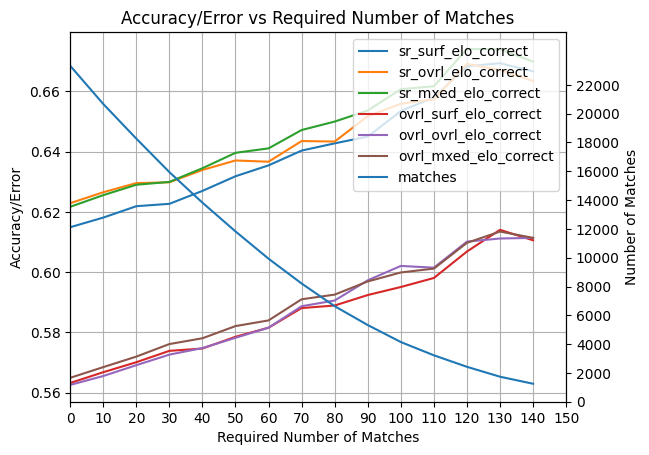

In [151]:
# val_keys = [
#     'sr_surf_elo_correct', 'sr_ovrl_elo_correct', 'sr_mxed_elo_correct',
#     'ovrl_surf_elo_correct', 'ovrl_ovrl_elo_correct', 'ovrl_mxed_elo_correct',
#     'ranking_correct',
#     'sr_surf_elo_err', 'sr_ovrl_elo_err', 'sr_mxed_elo_err',
#     'ovrl_surf_elo_err', 'ovrl_ovrl_elo_err', 'ovrl_mxed_elo_err', 'swr_err', 'rwr_err'
# ]
plot_metrics(['sr_surf_elo_correct', 'sr_ovrl_elo_correct', 'sr_mxed_elo_correct', 'ovrl_surf_elo_correct', 'ovrl_ovrl_elo_correct', 'ovrl_mxed_elo_correct'], index_map)

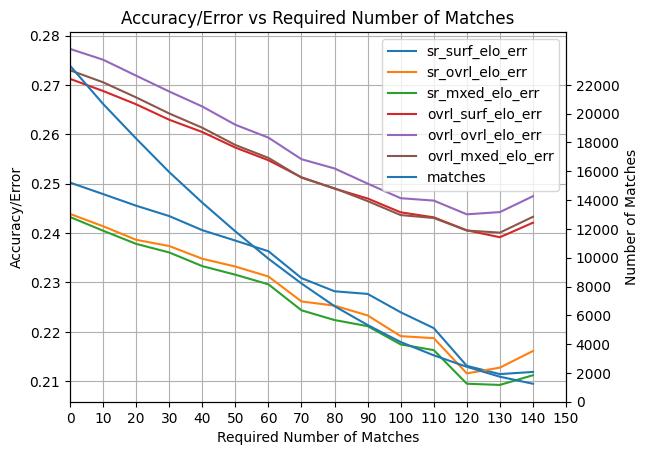

In [152]:
plot_metrics(['sr_surf_elo_err', 'sr_ovrl_elo_err', 'sr_mxed_elo_err', 'ovrl_surf_elo_err', 'ovrl_ovrl_elo_err', 'ovrl_mxed_elo_err'], index_map)

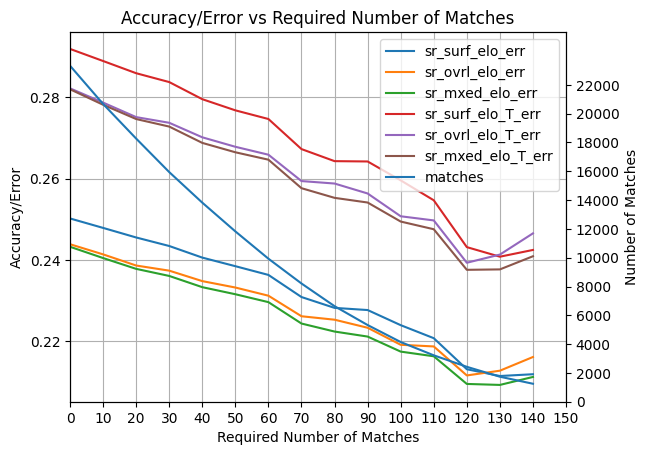

In [153]:
plot_metrics(['sr_surf_elo_err', 'sr_ovrl_elo_err', 'sr_mxed_elo_err', 'sr_surf_elo_T_err', 'sr_ovrl_elo_T_err', 'sr_mxed_elo_T_err'], index_map)

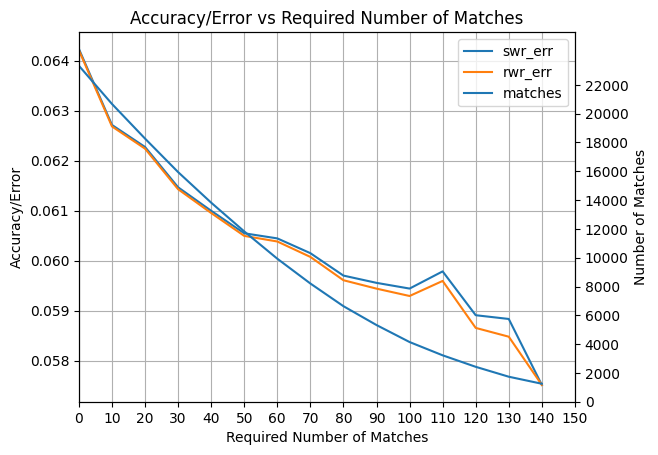

In [154]:
plot_metrics(['swr_err', 'rwr_err'], index_map)

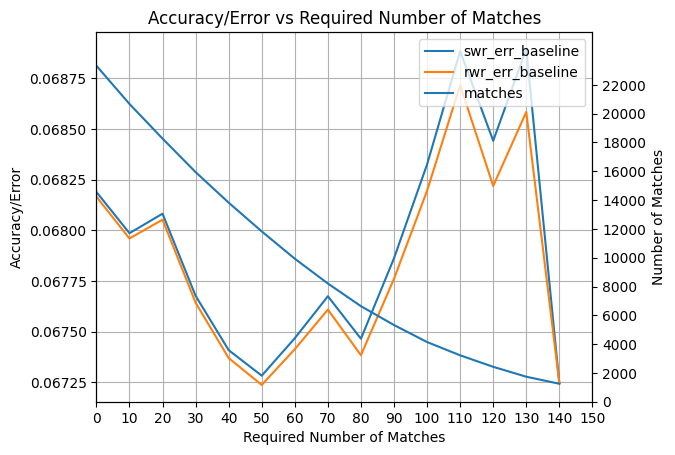

In [155]:
plot_metrics(['swr_err_baseline', 'rwr_err_baseline'], index_map)

In [156]:
ruud_df = pd.read_pickle(f'{df_root_dir}/CasperRuud.pkl')

100%|██████████| 195/195 [00:00<00:00, 505.77it/s]


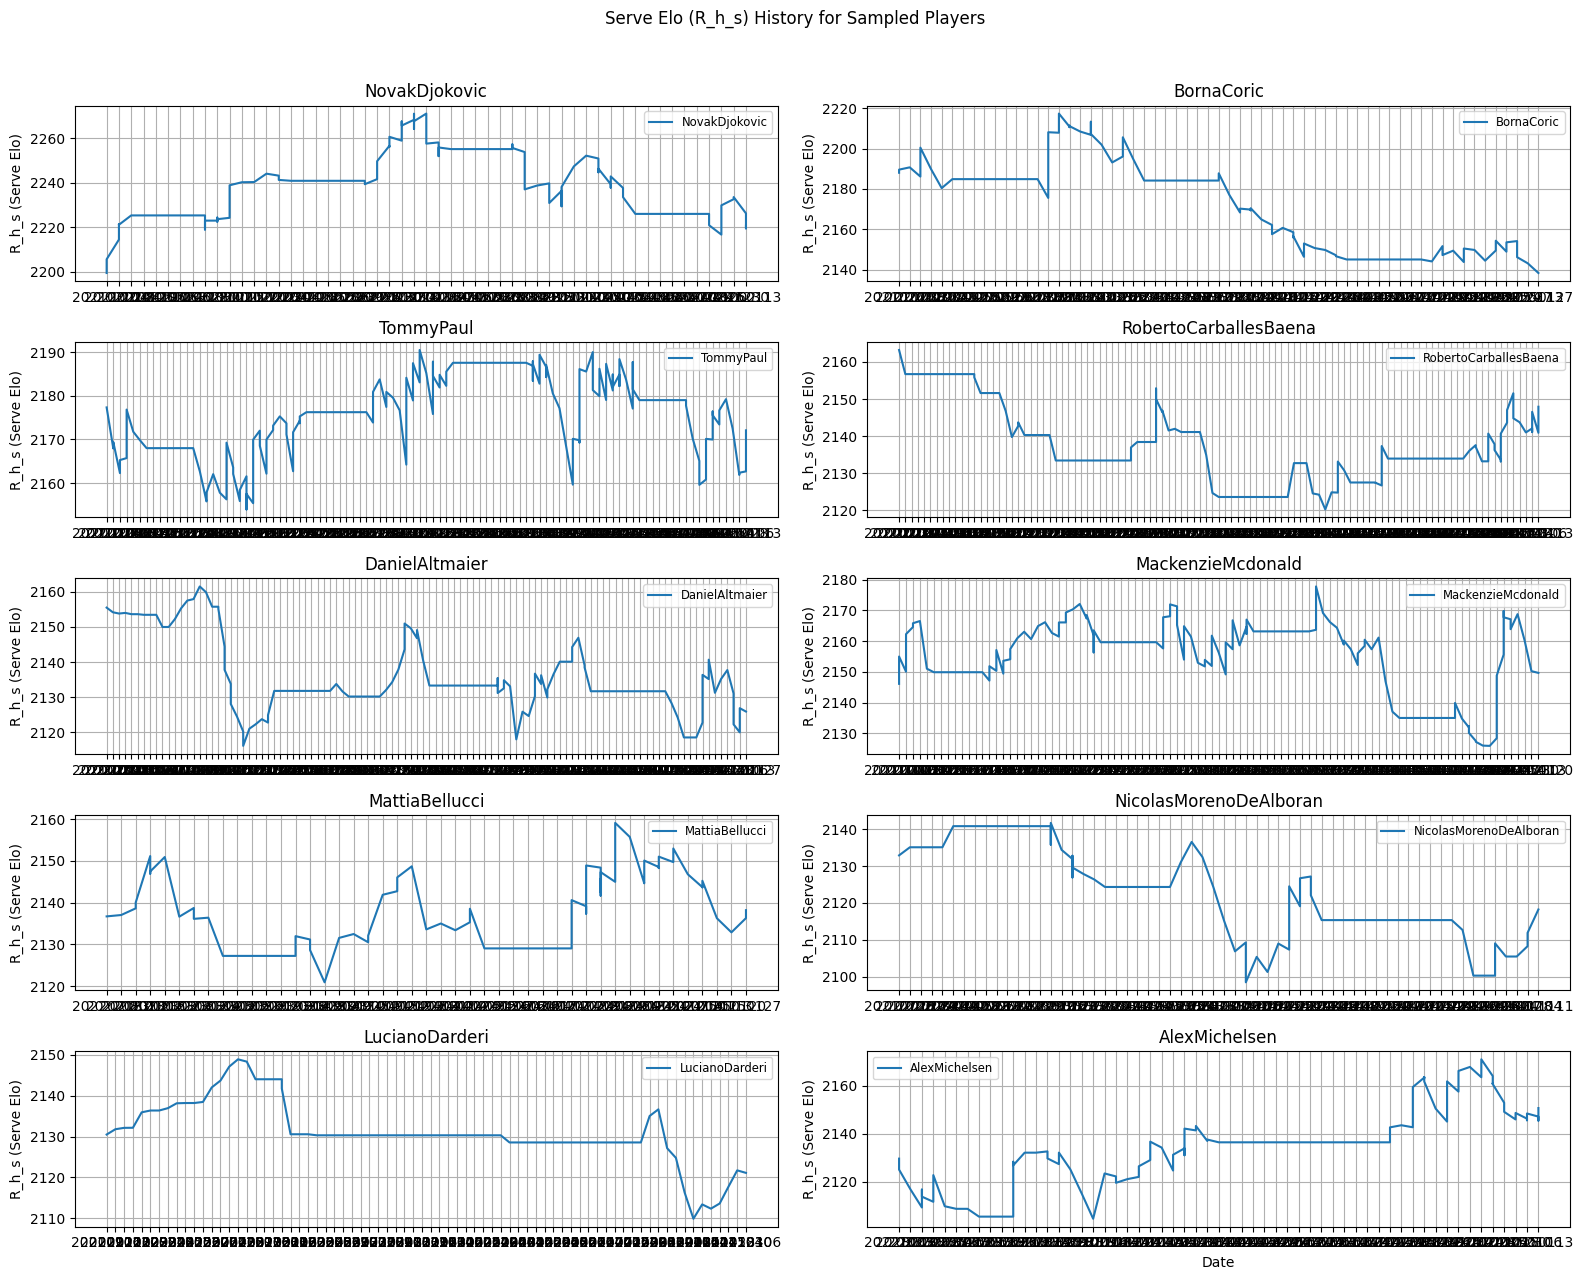

In [157]:
start_player_ratings = {}
for player in tqdm(top_200_names):
    p_df = pd.read_pickle(f'{df_root_dir}/{player}.pkl')
    p_df['ranking_superiority'] = p_df['rank'] > p_df['orank']
    p_df['result'] = (p_df['win/loss'] == 'W').astype(int)
    p_df['ranking_correct'] = ((p_df['ranking_superiority'] & (p_df['win/loss'] == 'W')) | (~p_df['ranking_superiority'] & (p_df['win/loss'] == 'L')))
    start_player_ratings[player] = {
        'start_elo_surf_serve': p_df.iloc[0]['R_h_s'],
        'start_elo_surf_return': p_df.iloc[0]['R_h_r'],
        'start_elo_surf_ovrl': p_df.iloc[0]['R_h_o'],
        'start_elo_ovrl_ovrl': p_df.iloc[0]['R_o_o'],
        'start_rank': p_df.iloc[0]['rank'],
    }

initial_player_rankings = np.array(sorted([(k, int(v['start_rank']) if v['start_rank'] else 1000) for k, v in start_player_ratings.items()], key=lambda x: x[1], reverse=False))
# print(initial_player_rankings[::10])
sampled_players = initial_player_rankings[::20, 0]
num_players = len(sampled_players)
fig, axes = plt.subplots(
    nrows=(num_players + 1) // 2,
    ncols=2,
    figsize=(16, 2.5 * ((num_players + 1) // 2)),
    sharex=False,  # Do not synchronize x axes
    sharey=False   # Do not synchronize y axes
)
axes = axes.flatten()

for idx, player in enumerate(sampled_players):
    p_df = pd.read_pickle(f'{df_root_dir}/{player}.pkl')
    axes[idx].plot(p_df['date'], p_df['R_h_s'], label=player)
    axes[idx].set_title(player)
    axes[idx].set_ylabel('R_h_s (Serve Elo)')
    axes[idx].grid(True)
    axes[idx].legend(fontsize='small')
for ax in axes[num_players:]:
    ax.axis('off')
plt.xlabel('Date')
plt.suptitle('Serve Elo (R_h_s) History for Sampled Players', y=1.02)
plt.tight_layout()
plt.show()

In [158]:
print(start_player_ratings['AlexMichelsen'])
darderi_df = pd.read_pickle(f'{df_root_dir}/LucianoDarderi.pkl')
vals = {'serve_win_rate': 0, 'matches': 0, 'service_pts': 0, 'first_serves_in': 0, 'first_serves_won': 0, 'second_serves_won': 0}
for player in tqdm(top_200_names):
    p_df = pd.read_pickle(f'{df_root_dir}/{player}.pkl')
    for k,v in vals.items():
        if k in p_df.columns:
            vals[k] += p_df[k].astype(float).sum()
    vals['matches'] += p_df.shape[0]

print(f"Average SWR: {vals['serve_win_rate']/vals['matches']:.2%}")
print(f"Average first serve in: {vals['first_serves_in']/vals['service_pts']:.2%}")
print(f"Average first serve win rate: {vals['first_serves_won']/vals['first_serves_in']:.2%}")
print(f"Average second serve win rate: {vals['second_serves_won']/(vals['service_pts'] - vals['first_serves_in']):.2%}")

{'start_elo_surf_serve': 2129.640900039508, 'start_elo_surf_return': 1959.3632446746462, 'start_elo_surf_ovrl': 1689.0606557260783, 'start_elo_ovrl_ovrl': 1689.0606557260783, 'start_rank': '913'}


100%|██████████| 195/195 [00:00<00:00, 793.60it/s]

Average SWR: 63.37%
Average first serve in: 62.50%
Average first serve win rate: 70.84%
Average second serve win rate: 50.54%


In [159]:
vals['matches']

23330

# Elo Results Comparison

## Results before redoing starting Elos:

**Accuracy:**
- SR SURF Elo Accuracy: 57.17%
- SR OVRL Elo Accuracy: 58.36%
- SR MXED Elo Accuracy: 57.84%
- OVRL SURF Elo Accuracy: 56.66%
- OVRL OVRL Elo Accuracy: 56.87%
- OVRL MXED Elo Accuracy: 56.81%
- Ranking Accuracy: 48.02%

**Error:**
- SR SURF Elo Error: 0.41
- SR OVRL Elo Error: 0.39
- SR MXED Elo Error: 0.40
- OVRL SURF Elo Error: 0.32
- OVRL OVRL Elo Error: 0.31
- OVRL MXED Elo Error: 0.31

## Results after redoing starting Elos:

**Accuracy:**
- SR SURF Elo Accuracy: 60.90%
- SR OVRL Elo Accuracy: 61.76%
- SR MXED Elo Accuracy: 61.40%
- OVRL SURF Elo Accuracy: 51.33%
- OVRL OVRL Elo Accuracy: 51.65%
- OVRL MXED Elo Accuracy: 51.37%
- Ranking Accuracy: 48.02%

**Error:**
- SR SURF Elo Error: 0.26
- SR OVRL Elo Error: 0.25
- SR MXED Elo Error: 0.25
- OVRL SURF Elo Error: 0.27
- OVRL OVRL Elo Error: 0.27
- OVRL MXED Elo Error: 0.27

## Results after filtering to out matches with a player with less than 50 recorded matches (Down to ~6000 matches total)

**Accuracy:**
- SR SURF Elo Accuracy: 62.49%
- SR OVRL Elo Accuracy: 63.38%
- SR MXED Elo Accuracy: 62.86%
- OVRL SURF Elo Accuracy: 57.75%
- OVRL OVRL Elo Accuracy: 57.71%
- OVRL MXED Elo Accuracy: 57.81%
- Ranking Accuracy: 47.03%

**Error:**
- SR SURF Elo Error: 0.25
- SR OVRL Elo Error: 0.23
- SR MXED Elo Error: 0.24
- OVRL SURF Elo Error: 0.26
- OVRL OVRL Elo Error: 0.26
- OVRL MXED Elo Error: 0.26



In [160]:
print(vals['matches'])

23330


In [161]:
ruud_df = pd.read_pickle(f'{df_root_dir}/CasperRuud.pkl')
sinner_df = pd.read_pickle(f'{df_root_dir}/JannikSinner.pkl')
dellien_df = pd.read_pickle(f'{df_root_dir}/HugoDellien.pkl')

In [162]:
swr, rwr, matches = 0,0,0
for player in tqdm(top_200_names):
    p_df = pd.read_pickle(f'{df_root_dir}/{player}.pkl')
    swr += p_df['serve_win_rate'].sum()
    rwr += p_df['return_win_rate'].sum()
    matches += p_df.shape[0]

swr /= matches
rwr /= matches
print(f"Average Serve Win Rate: {swr:.2%}")
print(f"Average Return Win Rate: {rwr:.2%}")
swr_all = np.concatenate([
    pd.read_pickle(f'{df_root_dir}/{player}.pkl')['serve_win_rate'].values
    for player in top_200_names
])
rwr_all = np.concatenate([
    pd.read_pickle(f'{df_root_dir}/{player}.pkl')['return_win_rate'].values
    for player in top_200_names
])
swr_median = np.median(swr_all)
rwr_median = np.median(rwr_all)
print(f"Median Serve Win Rate: {swr_median:.2%}")
print(f"Median Return Win Rate: {rwr_median:.2%}")


100%|██████████| 195/195 [00:00<00:00, 1012.84it/s]


Average Serve Win Rate: 63.37%
Average Return Win Rate: 36.63%
Median Serve Win Rate: 63.51%
Median Return Win Rate: 36.49%


In [163]:
# backup_all_dfs(top_200_names)